In [38]:
%matplotlib inline

from matplotlib import patches as mpatches
import numpy as np
import pandas as pd
import math
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly as pl
import plotly.graph_objs as go
from itertools import product
from __future__ import division
from bokeh.core.properties import Instance, String
from bokeh.models import LayoutDOM, CustomJS, Slider
from bokeh.layouts import row, widgetbox
from bokeh.plotting import ColumnDataSource
from bokeh.io import show, output_file

In [39]:
def plot_projections(ts, points, method_name):
    fig, ax = plt.subplots(figsize=(40, 40))
    ax.set_xlim([ts.min(), ts.max()])
    ax.set_ylim([points.min(), points.max()])
    
    red_patch = mpatches.Patch(color='red', label='X trajectory')
    green_patch = mpatches.Patch(color='green', label='Y trajectory ')
    blue_patch = mpatches.Patch(color='blue', label='Z trajectory')
    
    plt.legend(handles=[red_patch, green_patch, blue_patch], prop={'size':30}, loc=2)
    plt.title(method_name, size=30)
    ax.scatter(ts, points[:, 0], color='red', marker=',')
    ax.scatter(ts, points[:, 1], color='green', marker=',')
    ax.scatter(ts, points[:, 2], color='blue', marker=',')
    
def plot3D(points, method_name):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(points[:,0],points[:,1],points[:,2])

In [40]:
sigma = 10
b = 8.0/3
#dx/dt=-sigma*x+sigma*y
#dy/dt=-x*z+r*x-y
#dz/dt=x*y-b*z
def lorenz_fun(r, vec): 
    x,y,z=vec
    return np.array([sigma*(y-x), x*(r-z)-y, x*y-b*z])

In [41]:
start_x=np.array([10.0, -7.0, 4.0])

In [42]:
def converge_to(method, start_x):
    ts, points = method(start_x)
    return points[-1]

In [52]:
JS_CODE = """
# This file contains the JavaScript (CoffeeScript) implementation
# for a Bokeh custom extension. The "surface3d.py" contains the
# python counterpart.
#
# This custom model wraps one part of the third-party vis.js library:
#
#     http://visjs.org/index.html
#
# Making it easy to hook up python data analytics tools (NumPy, SciPy,
# Pandas, etc.) to web presentations using the Bokeh server.

# These "require" lines are similar to python "import" statements
import * as p from "core/properties"
import {LayoutDOM, LayoutDOMView} from "models/layouts/layout_dom"

# This defines some default options for the Graph3d feature of vis.js
# See: http://visjs.org/graph3d_examples.html for more details.
OPTIONS =
  width:  '700px'
  height: '700px'
  style: 'dot-color'
  showPerspective: true
  showGrid: true
  keepAspectRatio: true
  verticalRatio: 1.0
  showLegend: false
  cameraPosition:
    horizontal: -0.35
    vertical: 0.22
    distance: 1.8
  dotSizeRatio: 0.0005




# To create custom model extensions that will render on to the HTML canvas
# or into the DOM, we must create a View subclass for the model. Currently
# Bokeh models and views are based on BackBone. More information about
# using Backbone can be found here:
#
#     http://backbonejs.org/
#
# In this case we will subclass from the existing BokehJS ``LayoutDOMView``,
# corresponding to our
export class Surface3dView extends LayoutDOMView

  initialize: (options) ->
    super(options)

    url = "http://visjs.org/dist/vis.js"

    script = document.createElement('script')
    script.src = url
    script.async = false
    script.onreadystatechange = script.onload = () => @_init()
    document.querySelector("head").appendChild(script)

  _init: () ->
    # Create a new Graph3s using the vis.js API. This assumes the vis.js has
    # already been loaded (e.g. in a custom app template). In the future Bokeh
    # models will be able to specify and load external scripts automatically.
    #
    # Backbone Views create <div> elements by default, accessible as @el. Many
    # Bokeh views ignore this default <div>, and instead do things like draw
    # to the HTML canvas. In this case though, we use the <div> to attach a
    # Graph3d to the DOM.
    @_graph = new vis.Graph3d(@el, @get_data(), OPTIONS)

    # Set Backbone listener so that when the Bokeh data source has a change
    # event, we can process the new data
    @connect(@model.data_source.change, () =>
        @_graph.setData(@get_data())
    )

  # This is the callback executed when the Bokeh data has an change. Its basic
  # function is to adapt the Bokeh data source to the vis.js DataSet format.
  get_data: () ->
    data = new vis.DataSet()
    source = @model.data_source
    for i in [0...source.get_length()]
      data.add({
        x:     source.get_column(@model.x)[i]
        y:     source.get_column(@model.y)[i]
        z:     source.get_column(@model.z)[i]
        extra: source.get_column(@model.extra)[i]
        style: source.get_column(@model.color)[i]
      })
    return data

# We must also create a corresponding JavaScript Backbone model sublcass to
# correspond to the python Bokeh model subclass. In this case, since we want
# an element that can position itself in the DOM according to a Bokeh layout,
# we subclass from ``LayoutDOM``
export class Surface3d extends LayoutDOM

  # This is usually boilerplate. In some cases there may not be a view.
  default_view: Surface3dView

  # The ``type`` class attribute should generally match exactly the name
  # of the corresponding Python class.
  type: "Surface3d"

  # The @define block adds corresponding "properties" to the JS model. These
  # should basically line up 1-1 with the Python model class. Most property
  # types have counterparts, e.g. ``bokeh.core.properties.String`` will be
  # ``p.String`` in the JS implementatin. Where the JS type system is not yet
  # as rich, you can use ``p.Any`` as a "wildcard" property type.
  @define {
    x:           [ p.String           ]
    y:           [ p.String           ]
    z:           [ p.String           ]
    color:       [ p.String           ]
    extra:       [ p.String           ]
    data_source: [ p.Instance         ]
  }
"""

# This custom extension model will have a DOM view that should layout-able in
# Bokeh layouts, so use ``LayoutDOM`` as the base class. If you wanted to create
# a custom tool, you could inherit from ``Tool``, or from ``Glyph`` if you
# wanted to create a custom glyph, etc.
class Surface3d(LayoutDOM):

    # The special class attribute ``__implementation__`` should contain a string
    # of JavaScript (or CoffeeScript) code that implements the JavaScript side
    # of the custom extension model.
    __implementation__ = JS_CODE

    # Below are all the "properties" for this model. Bokeh properties are
    # class attributes that define the fields (and their types) that can be
    # communicated automatically between Python and the browser. Properties
    # also support type validation. More information about properties in
    # can be found here:
    #
    #    https://bokeh.pydata.org/en/latest/docs/reference/core.html#bokeh-core-properties

    # This is a Bokeh ColumnDataSource that can be updated in the Bokeh
    # server by Python code
    data_source = Instance(ColumnDataSource)

    # The vis.js library that we are wrapping expects data for x, y, z, and
    # color. The data will actually be stored in the ColumnDataSource, but
    # these properties let us specify the *name* of the column that should
    # be used for each field.
    x = String
    y = String
    z = String
    extra = String
    color = String


def generate_data_set(method_name, method, start_x, r, t_a=0, t_b=100, dt=0.001):
    
    df = pd.DataFrame()
    
    for i in range(1,11):
        fun = lambda vec: lorenz_fun(r, vec)
        ts, x_3d = method(start_x, r, fun, t_a, t_b, dt)

        df['x' + str(i)] = pd.Series(x_3d.T[0])
        df['y' + str(i)] = pd.Series(x_3d.T[1])
        df['z' + str(i)] = pd.Series(x_3d.T[2])
    
    df['x'] = df['x6']
    df['y'] = df['y6']
    df['z'] = df['z6']
    df['color'] = pd.Series(np.asarray([0 for x in range(len(df['x']))]))
    df['extra'] = pd.Series(np.asarray(['point' for x in range(len(df['x']))]))
    
    return ColumnDataSource(df)
    
def draw_plot(method_name, method, start_x, r, t_a=0, t_b=100, dt=0.01):
    source = generate_data_set(method_name, method, start_x, r, t_a=0, t_b=100, dt=0.01)

    surface = Surface3d(x="x", y="y", z="z", extra="extra", color="color", data_source=source)
    
    callback = CustomJS(args=dict(source=source), code="""
        var data = source.data;
        var rv = r.get('value');
        y = data['y'];
        data['y'] = data['y' + rv];
        source.change.emit();
    """)

    r_slider = Slider(start=1, end=10, value=6, step=1,
                        title="r", callback=callback)
    callback.args["r"] = r_slider

    layout = row(
        surface,
        widgetbox(r_slider),
    )

    output_file("slider.html", title="slider.py example")

    show(layout) 

In [53]:
def plot_graphs(method_name, method, start_x, r, t_a=0, t_b=100, dt=0.001):
    fun = lambda vec: lorenz_fun(r, vec)
    ts, points = method(start_x, r, fun, t_a, t_b, dt)
    print(points[-1])
#     np.savetxt("Debug/Content/data.csv", points, delimiter=' ')
    plot_projections(ts, points, method_name)
    plot3D(points, method_name)

In [54]:
def euler_method(start_x, r, fun=None, t_a=0, t_b=100, dt=0.001):
    if fun is None:
        fun = lambda vec: lorenz_fun(r, vec)
    cur_t = t_a
    cur_x = np.copy(start_x)
    ts = [cur_t]
    way = [cur_x]
    while cur_t <= t_b:
        cur_x += fun(cur_x)*dt
        cur_t += dt
        way.append(np.copy(cur_x))
        ts.append(cur_t)
    return (np.array(ts), np.array(way))

[11.6784086   8.30075448 31.18549149]


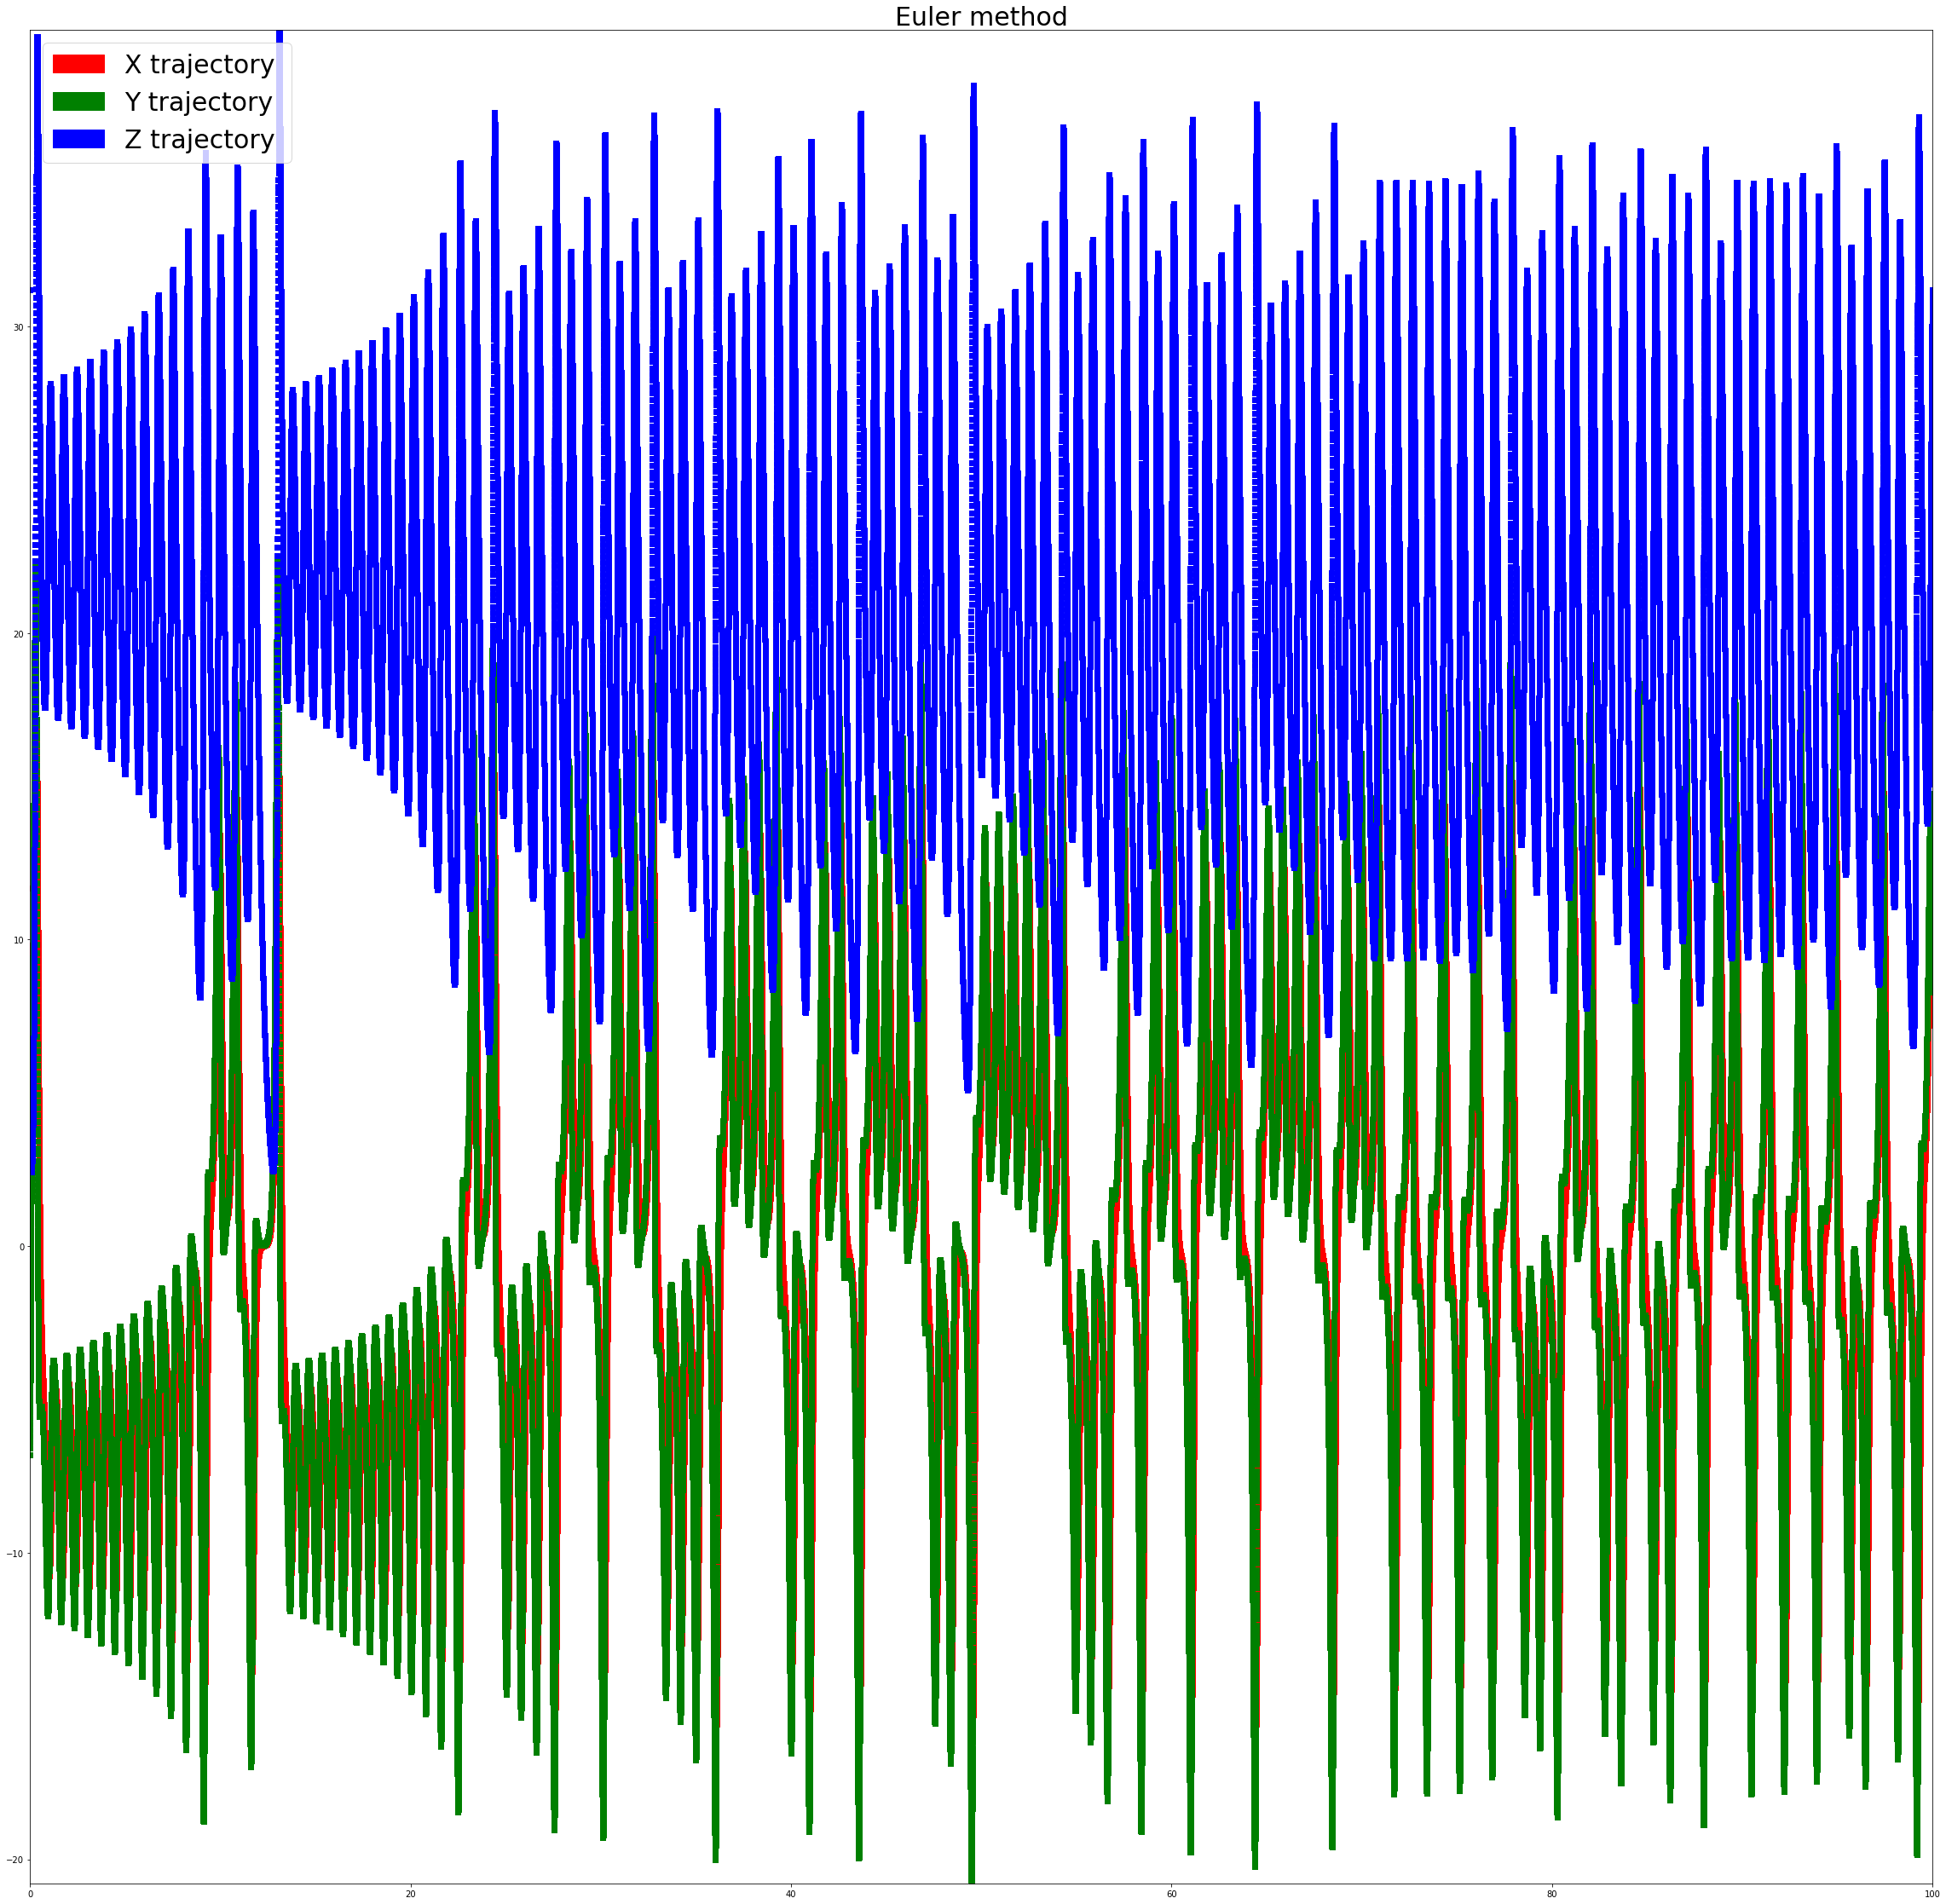

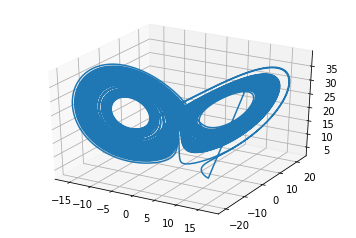

In [81]:
plot_graphs(method_name = "Euler method", 
            method = euler_method, 
            start_x = [10.0, -7.0, 4.0],
            r = 24)
draw_plot(method_name = "Euler method", 
            method = euler_method, 
            start_x = [10.0, -7.0, 4.0],
            r = 24)

In [65]:
def runge_kutta_method(start_x, r, fun=None, t_a=0, t_b=100, dt=0.001):
    if fun is None:
        fun = lambda vec: lorenz_fun(r, vec)
    cur_t = t_a
    cur_x = np.copy(start_x)
    ts = [cur_t]
    way = [cur_x]
    while cur_t <= t_b:
        k1 = fun(cur_x)
        k2 = fun(cur_x+dt*0.5*k1)
        k3 = fun(cur_x+dt*0.5*k2)
        k4 = fun(cur_x+dt*k3)
        cur_x = cur_x+dt/6*(k1+2*k2+2*k3+k4)
        cur_t += dt
        way.append(np.copy(cur_x))
        ts.append(cur_t)
    return (np.array(ts), np.array(way))

[13.52805794 16.71387219 26.58228035]


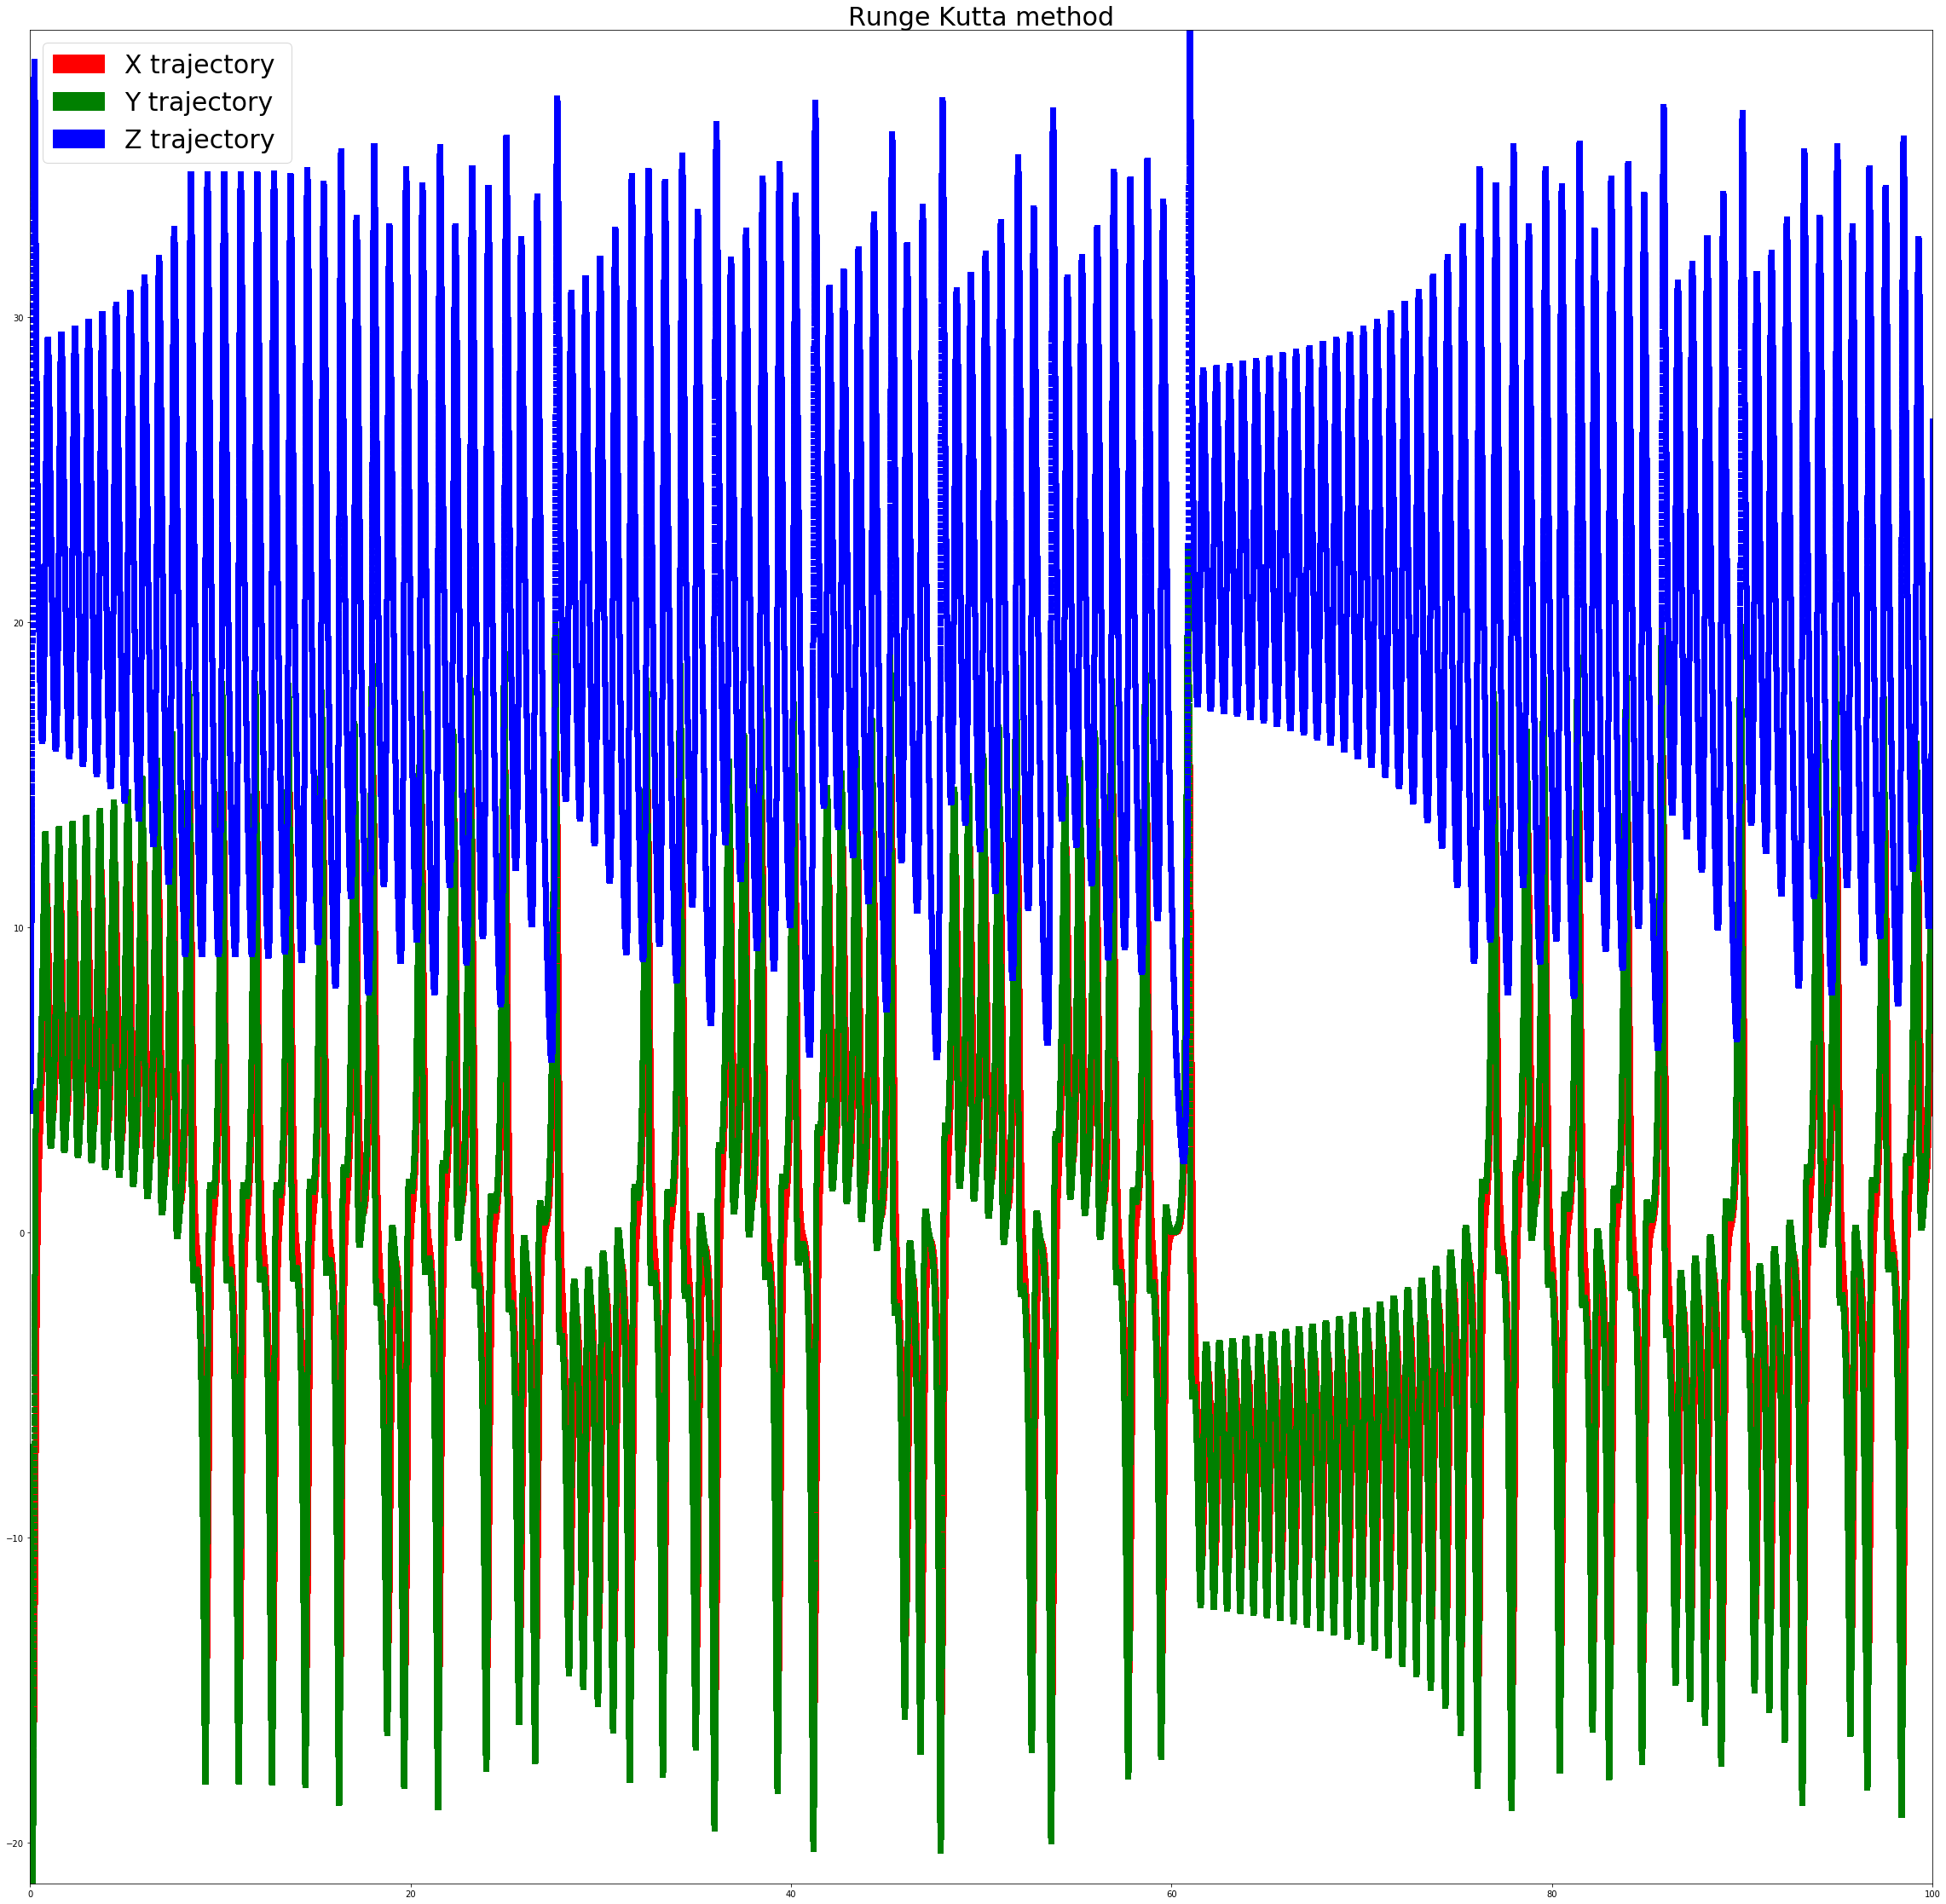

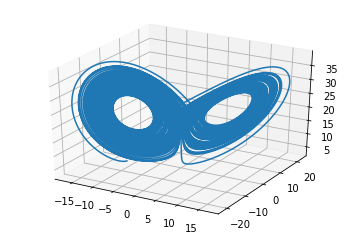

In [87]:
plot_graphs(method_name = "Runge Kutta method", 
            method = runge_kutta_method, 
            start_x = [-10.0, -7.0, 4.0],
            r = 24)
draw_plot(method_name = "Runge Kutta method", 
            method = runge_kutta_method, 
            start_x = [-10.0, -7.0, 4.0],
            r = 24)

In [60]:
EPS = 1e-9

def solve_cubic_equation(u, y0): # solves y=u(y) using Newton
    h = np.polysub(u, np.array([1, 0]))
    dh = np.polyder(h)
    
    cur_y = y0
    next_y = cur_y - np.polyval(h, cur_y) / np.polyval(dh, cur_y)
    while (np.abs(np.polyval(h, cur_y)) > EPS):
        cur_y = np.copy(next_y)
        next_y = cur_y - np.polyval(h, cur_y) / np.polyval(dh, cur_y)
    return cur_y

def solve_system_equality(cur_x, dt, r):
    x0, y0, z0 = cur_x
    ax = np.array([dt*sigma, x0]) / (1+dt*sigma)
     
    az = np.polyadd(np.polymul(ax, np.array([1, 0]))*dt, 
                    np.array([z0])) / (1+dt*b)    
    
    # y=y0-dt*ax*az+dt*r*ax
    fixy = np.array([0,y0])
    fixy = np.polysub(fixy, dt*np.polymul(ax,az))
    fixy = np.polyadd(fixy, dt*r*ax)
    fixy = np.polysub(fixy, np.array([dt, 0]))
    
    ny = solve_cubic_equation(fixy, y0)
    nx = np.polyval(ax, ny)
    nz = np.polyval(az, ny)
    result = np.array([nx, ny, nz])
    return result

def implicit_euler_method(start_x, r, fun=None, t_a=0, t_b=20, dt=0.001):
    cur_t = t_a
    cur_x = np.copy(start_x)
    ts = [cur_t]
    way = [cur_x]
    while cur_t <= t_b:
        cur_x = solve_system_equality(cur_x, dt, r)
        cur_t += dt
        way.append(np.copy(cur_x))
        ts.append(cur_t)
    return (np.array(ts), np.array(way))

[-7.8409876  -7.83602044 23.017784  ]


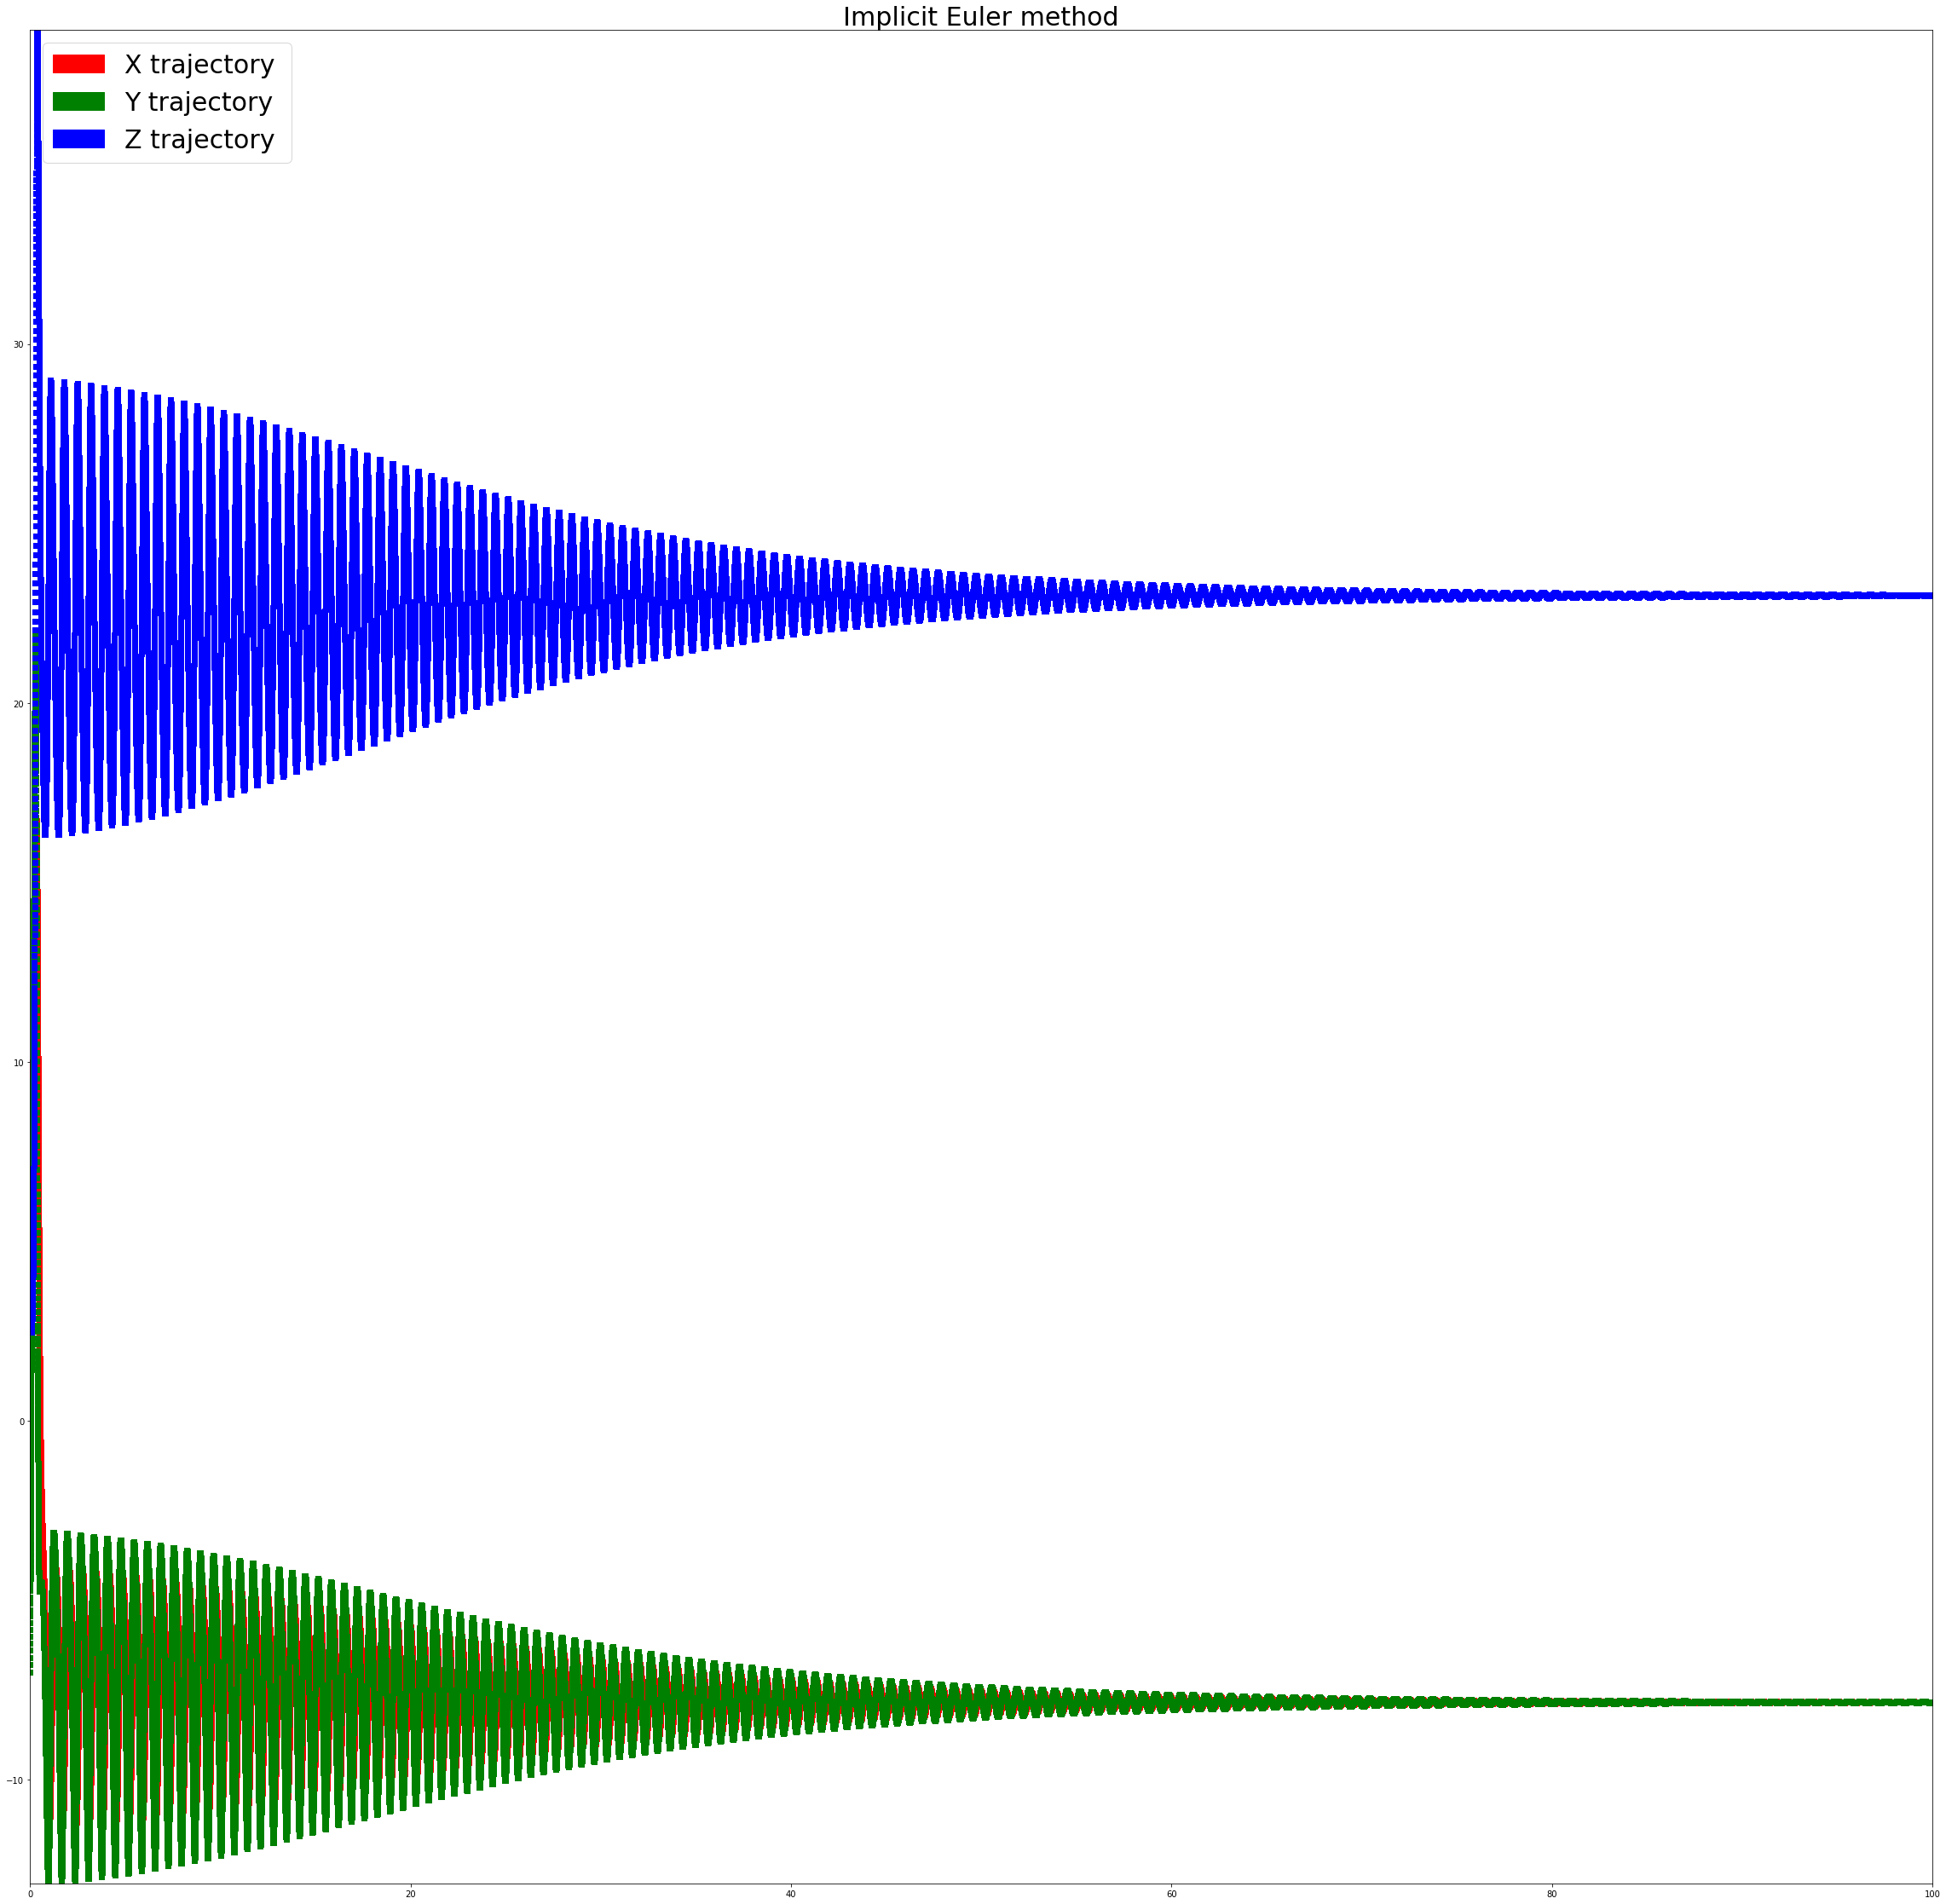

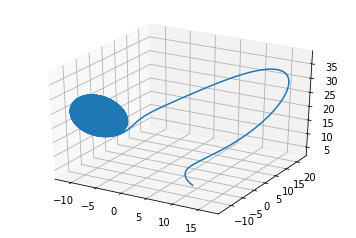

In [82]:
plot_graphs(method_name = "Implicit Euler method", 
            method = implicit_euler_method, 
            start_x = [10.0, -7.0, 4.0],
            r = 24)
draw_plot(method_name = "Implicit Euler method", 
            method = implicit_euler_method, 
            start_x = [10.0, -7.0, 4.0],
            r = 24)

In [63]:
def adams_method(start_x, r, fun=None, t_a=0, t_b=100, dt=0.001):
    if fun is None:
        fun = lambda vec: lorenz_fun(r, vec)
    cur_t = t_a
    cur_x = np.copy(start_x)
    ts = [cur_t]
    way = [cur_x]
    while cur_t <= t_b:
        if len(way) <= 4:
            if len(way) == 1:
                cur_x += fun(cur_x) * dt
            else:
                p0 = fun(way[len(way) - 1])
                p1 = fun(way[len(way) - 2])
                pred = cur_x - (dt / 2) * (p1 - 3 * p0)
                p_1 = fun(pred)
                corr = cur_x + (dt / 2) * (p0 + p_1)
                cur_x = np.copy(corr)
        else:
            p0 = fun(way[len(way) - 1])
            p1 = fun(way[len(way) - 2])
            p2 = fun(way[len(way) - 3])
            p3 = fun(way[len(way) - 4])
            pred = cur_x + (dt / 24) * (55 * p0 - 59 * p1 + 37 * p2 - 9 * p3)
            p_1 = fun(pred)
            corr = cur_x + (dt / 24) * (9 * p_1 + 19 * p0 - 5 * p1 + p2)
            cur_x = np.copy(corr)
            
        cur_t += dt
        way.append(np.copy(cur_x))
        ts.append(cur_t)
            
    return (np.array(ts), np.array(way))

[-1.53154814 -1.15393013 17.0193239 ]


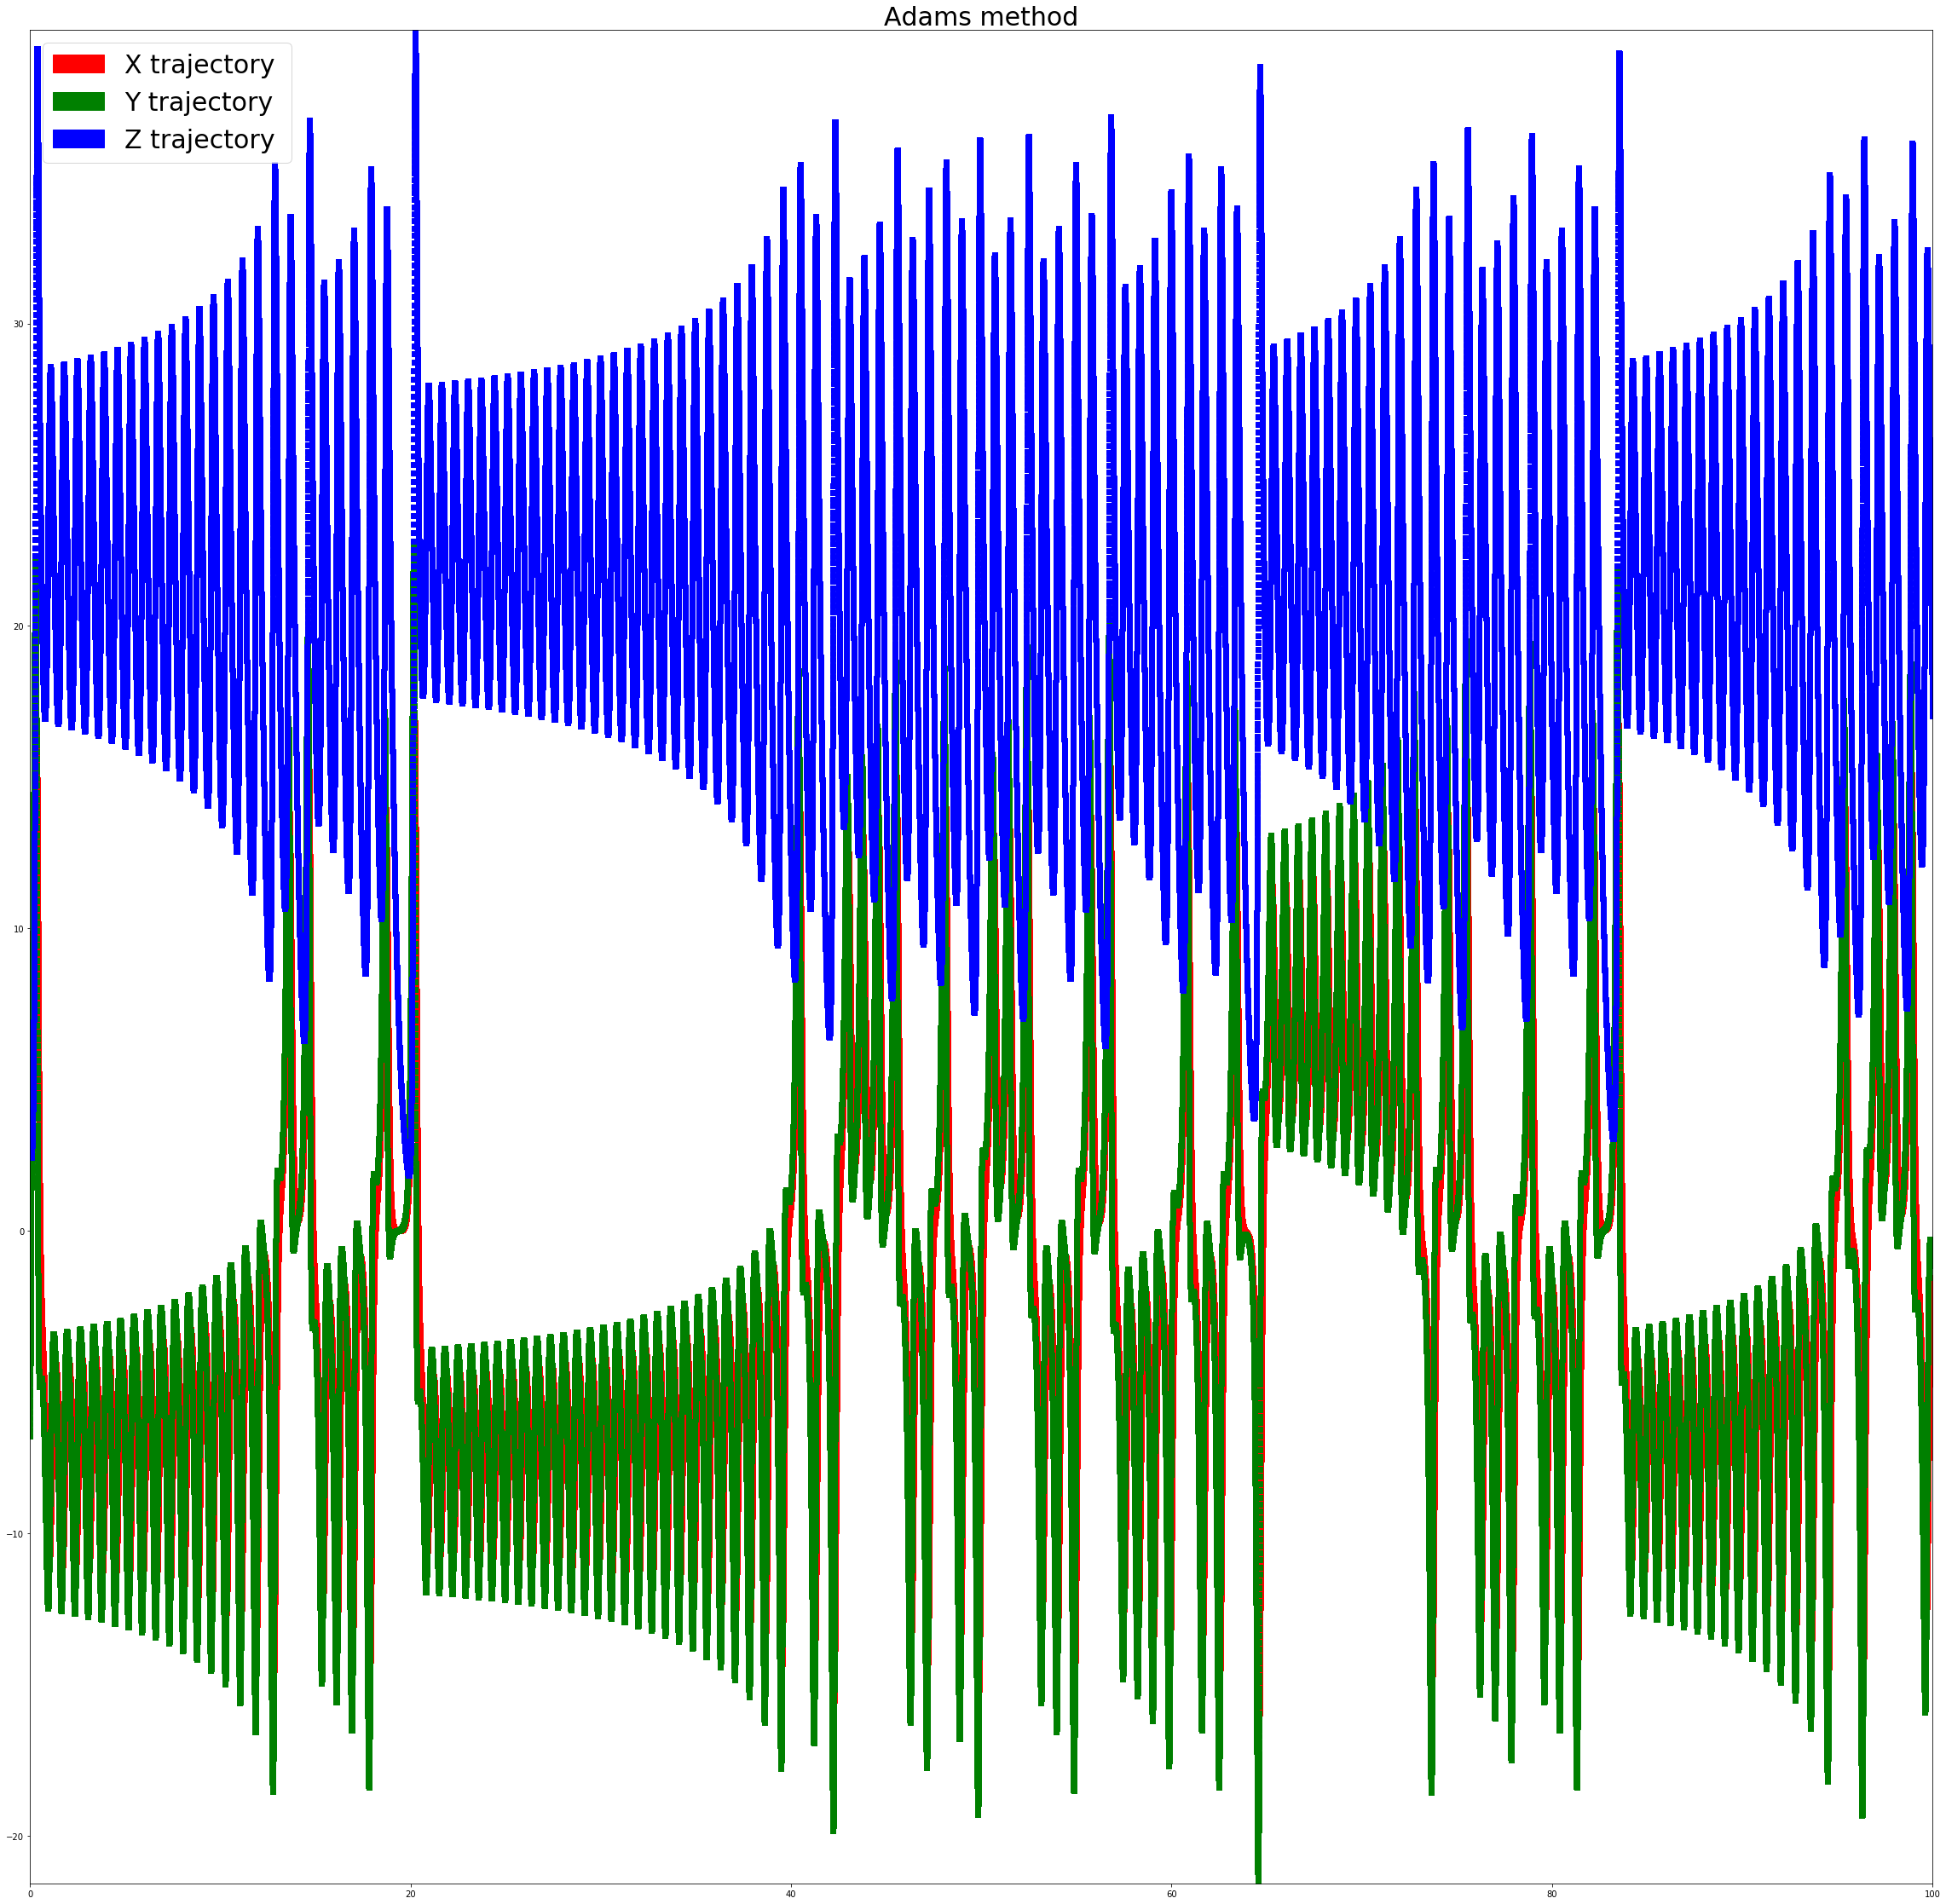

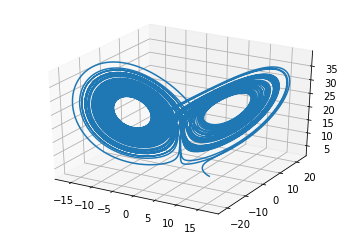

In [83]:
plot_graphs(method_name = "Adams method",
            method = adams_method,
            start_x = [10.0, -7.0, 4.0],
            r = 24)
draw_plot(method_name = "Adams method", 
            method = adams_method, 
            start_x = [10.0, -7.0, 4.0],
            r = 24)

In [36]:
def final_points(method, start_x):
    global r
    for r_id in range(100):
        r = 30.0 * r_id / 100
        x, y, z = converge_to(method, start_x)
        print("%.2f converjed to (%.3f %3.f %3.f)" % (r, x, y, z))

In [ ]:
np.savetxt("data.csv", points, delimiter=' ')